# Case study: US daily Covid 19 data

## Importing required libraries

In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from statsmodels.tsa.api                  import  ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## importing data

In [2]:
df=pd.read_csv('us_covid19_daily.csv',parse_dates=True)

In [3]:
df.head()

,Date,Positive,Hospitalized,Death
0,17-03-2020,10021,325,124
1,18-03-2020,13385,416,155
2,19-03-2020,18085,617,203
3,20-03-2020,24197,1042,273
4,21-03-2020,31013,1492,335


In [4]:
df.tail()

,Date,Positive,Hospitalized,Death
260,02-12-2020,13711156,100322,264522
261,03-12-2020,13921360,100755,267228
262,04-12-2020,14146191,101276,269791
263,05-12-2020,14357264,101190,272236
264,06-12-2020,14534035,101487,273374


### Data is collecetd for the period of 17th March 2020 to 06th December 2020. Data is collected on daily basis for Positive cases, Hospitalized and Death count

## converting data into time series

In [5]:
date = pd.date_range(start='3/17/2020', end='12/6/2020', freq='D')
date

DatetimeIndex(['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26',
               ...
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06'],
              dtype='datetime64[ns]', length=265, freq='D')

In [6]:
df['Time_Stamp'] = pd.DataFrame(date)

In [7]:
df=df.set_index('Time_Stamp')

In [8]:
df.head()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-03-17,17-03-2020,10021,325,124
2020-03-18,18-03-2020,13385,416,155
2020-03-19,19-03-2020,18085,617,203
2020-03-20,20-03-2020,24197,1042,273
2020-03-21,21-03-2020,31013,1492,335


In [9]:
df.tail()

,Date,Positive,Hospitalized,Death
Time_Stamp,,,,
2020-12-02,02-12-2020,13711156,100322,264522
2020-12-03,03-12-2020,13921360,100755,267228
2020-12-04,04-12-2020,14146191,101276,269791
2020-12-05,05-12-2020,14357264,101190,272236
2020-12-06,06-12-2020,14534035,101487,273374


In [10]:
df.shape

(265, 4)

### For this case study, we will build time series model to forecast the Hospitalized count

## plotting variable Hospitalized 

<AxesSubplot:xlabel='Time_Stamp'>

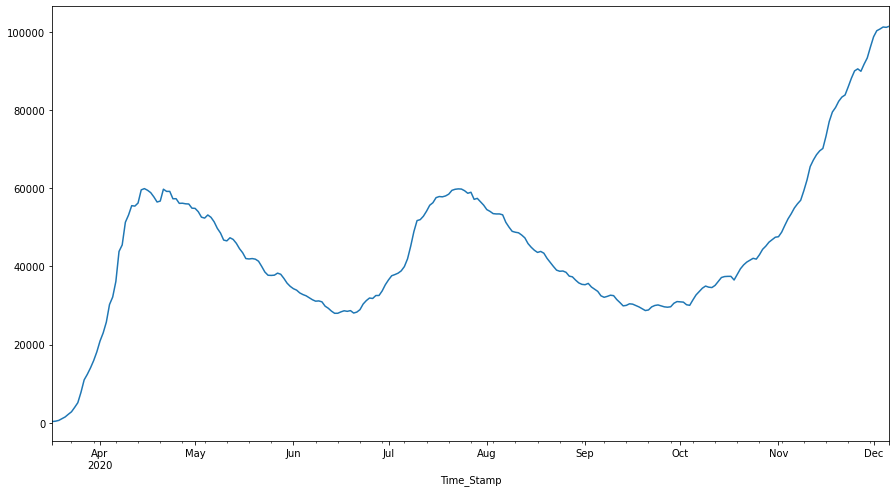

In [11]:
rcParams['figure.figsize'] = 15,8
df['Hospitalized'].plot()

In [12]:
df_final=df.drop(['Date','Positive','Death'],axis=1)

In [13]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [14]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


## Checking for Null values

In [15]:
df_final.isnull().sum()

Hospitalized    0
dtype: int64

### data does not have any missing values

## Exploratory Data Analysis

In [16]:
rcParams['figure.figsize'] = 15,10

<AxesSubplot:xlabel='Time_Stamp'>

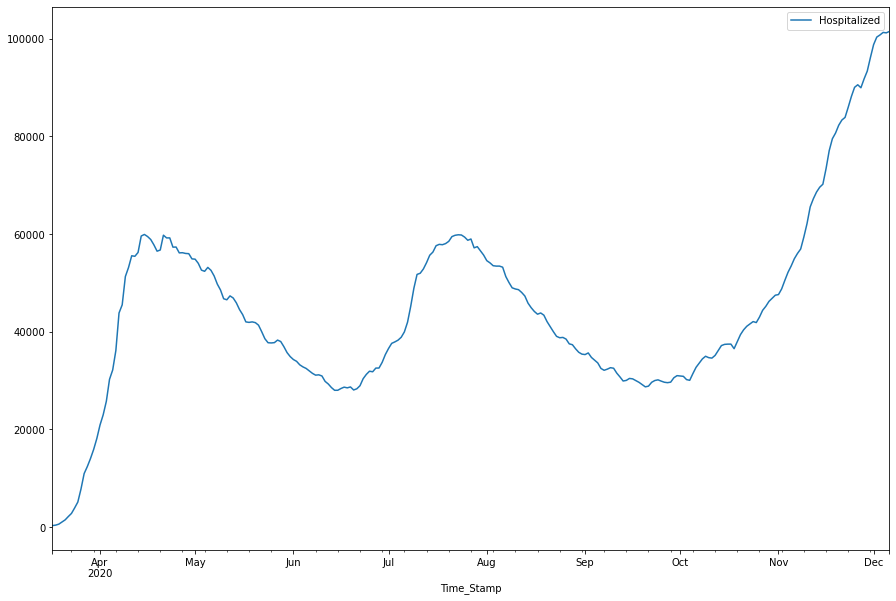

In [17]:
df_final.plot()

### plotting box-plot for distribution of data

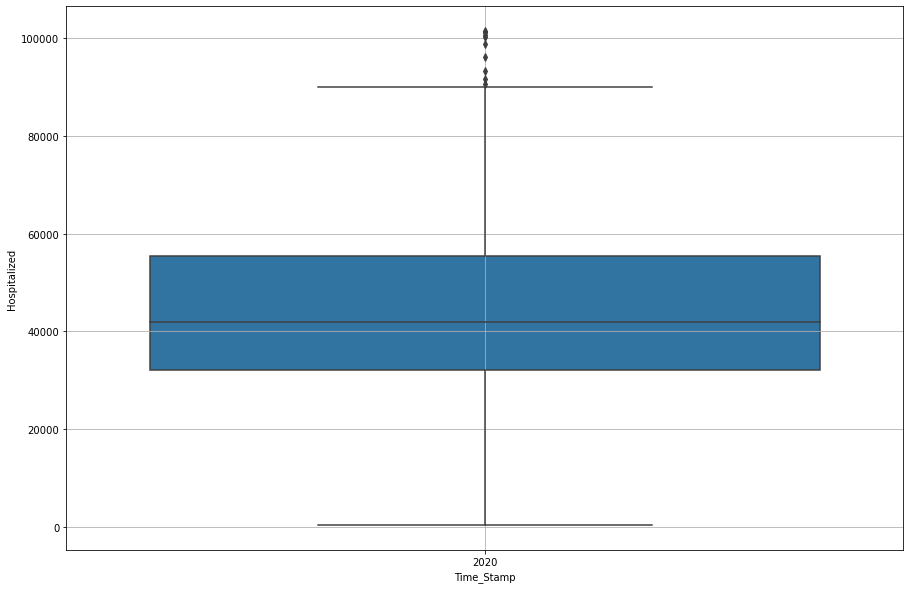

In [18]:
sns.boxplot(x = df_final.index.year,y = df_final['Hospitalized'])
plt.grid();

## plotting monthwise distribution

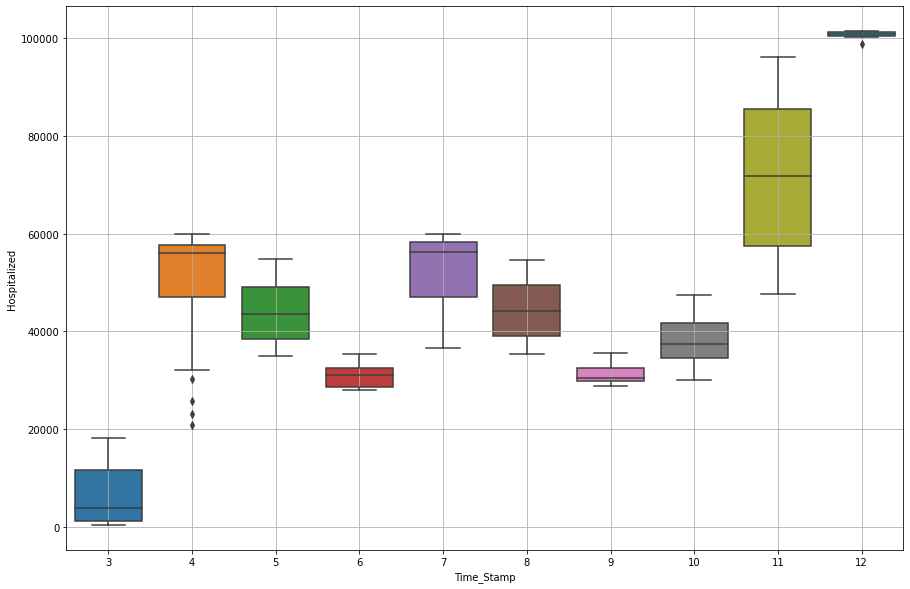

In [19]:
sns.boxplot(x = df_final.index.month,y = df_final['Hospitalized'])
plt.grid();

### High variation in data can be observed in the month of November. Few outliers are present in the month of April

## Decomposing time series

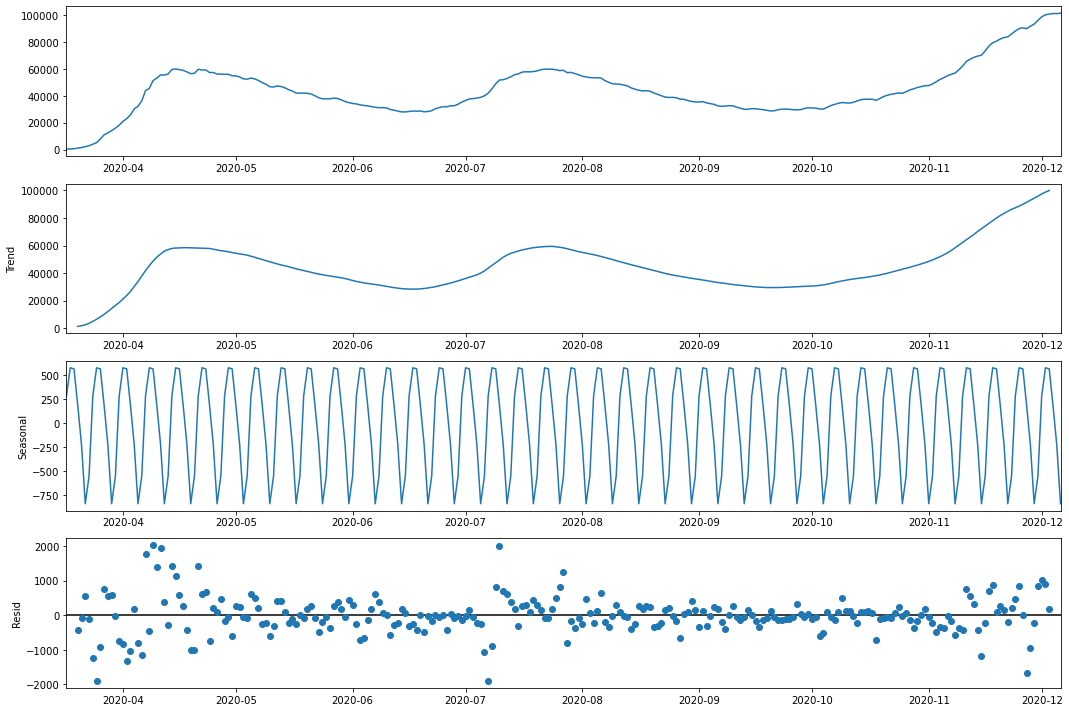

In [20]:
decomposition = seasonal_decompose(df_final, model = 'additive')
decomposition.plot()
plt.show()

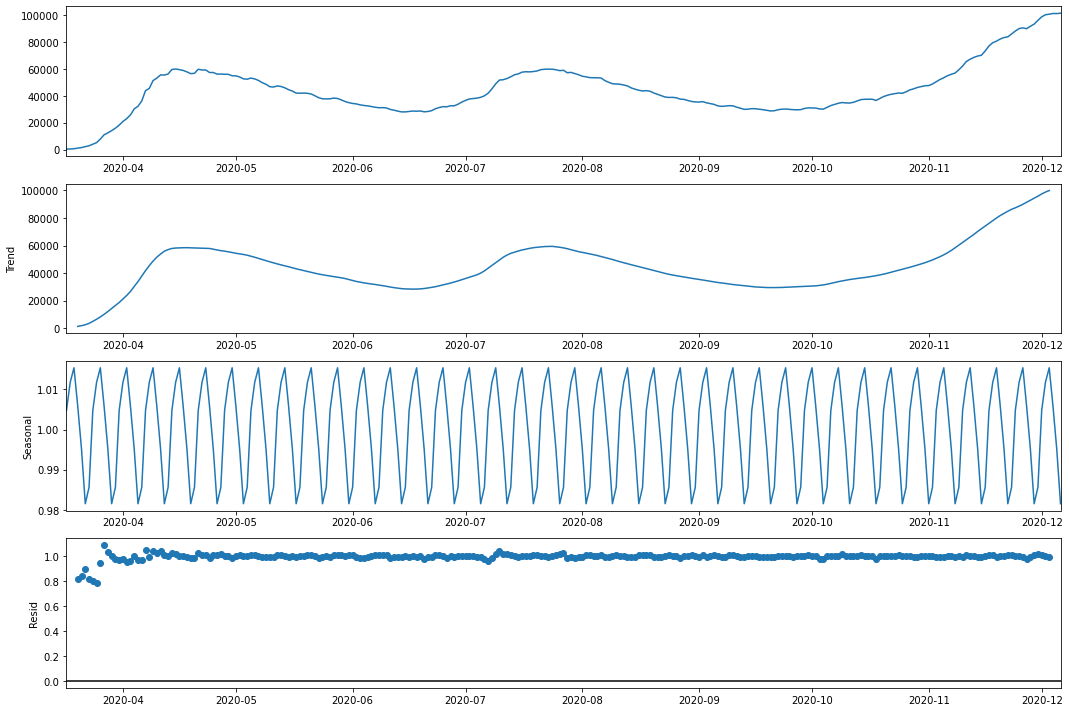

In [21]:
decomposition = seasonal_decompose(df_final, model = 'multiplicative')
decomposition.plot()
plt.show()

### Time series is showing trend as well as seasonality. Residual curve confirms that series is Multiplicative

## Looking for stationarity

### plotting monthly mean

<AxesSubplot:xlabel='Time_Stamp'>

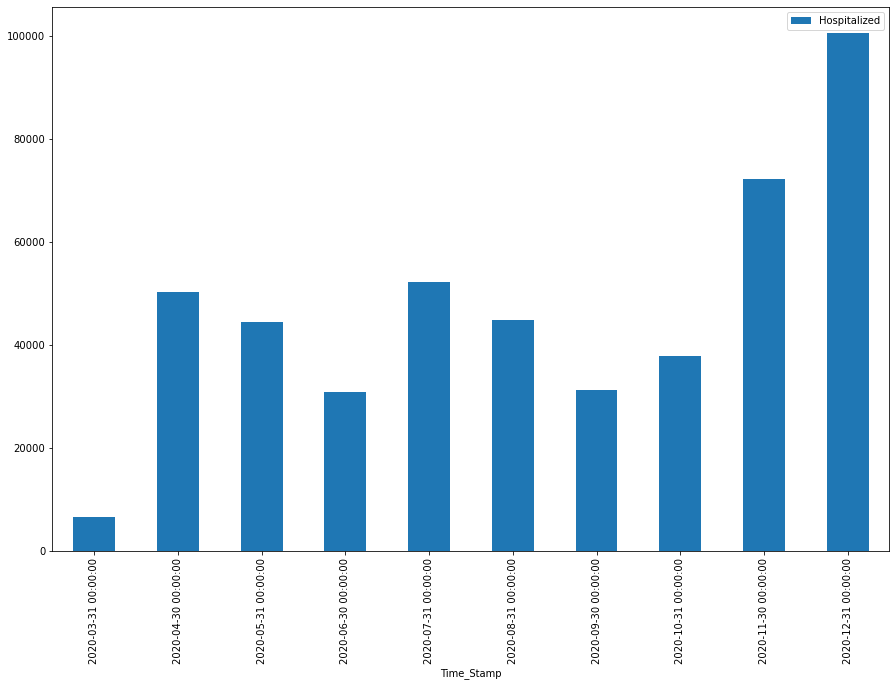

In [22]:
monthly_mean = df_final.resample('M').mean()
monthly_mean.plot.bar()

### Variation in monthly mean plot is indicating that series is non-stationary

## lets plot rolling mean and std deviation

In [23]:
rolmean = df_final.rolling(window=30).mean()
rolstd = df_final.rolling(window=30).std()

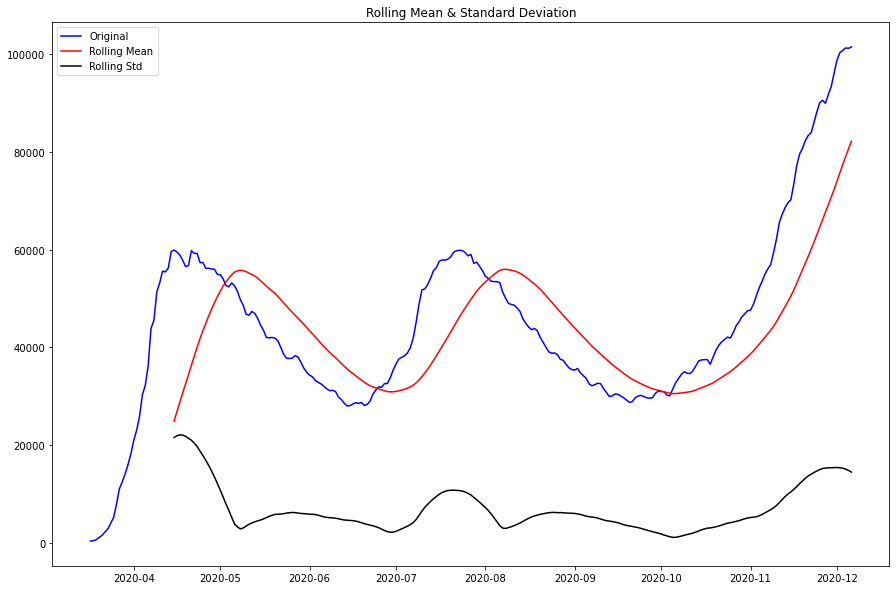

In [24]:
orig = plt.plot(df_final, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

### both rolling mean and std deviation are changing over the period of time

## statistical test to confirm the stationarity

In [25]:
observations= df_final.values
test_result = adfuller(observations)

In [26]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -1.631167
p-value: 0.466880
Critical Values:
	1%: -3.45700
	5%: -2.87327
	10%: -2.57302


### Test result confirms that series is non-stationary

## ACF and PACF plots for the series

In [27]:
df_diff=df_final.diff().dropna()

In [28]:
observations= df_diff.values
test_result = adfuller(observations)

In [29]:
test_result

(-2.9950931929348075,
 0.0353551821602152,
 15,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 4006.0600164511907)

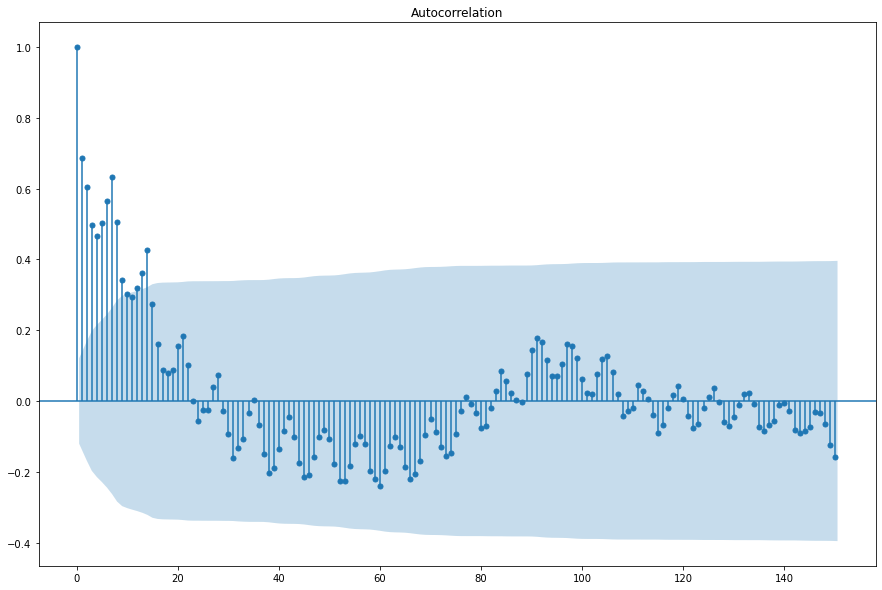

In [30]:
plot_acf(df_diff,lags=150);

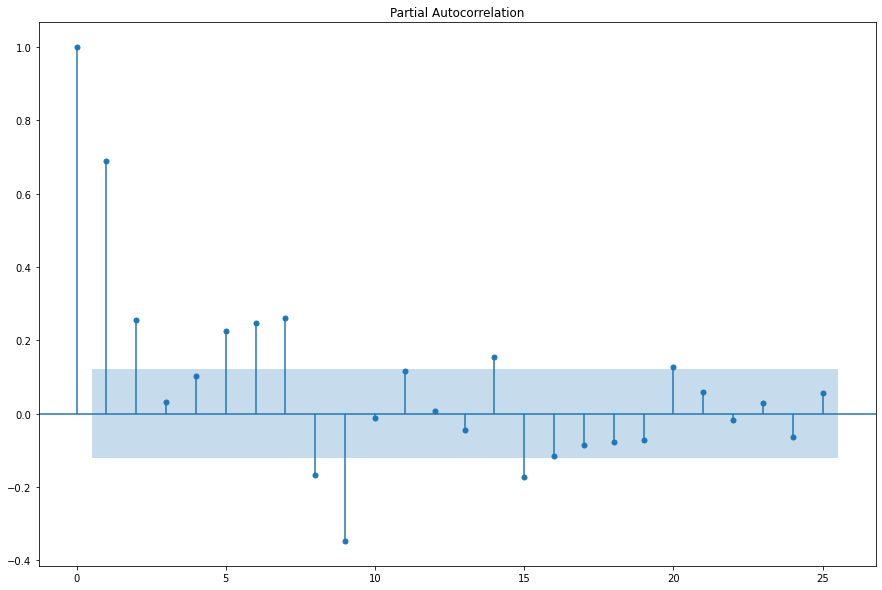

In [31]:
plot_pacf(df_diff);

### ACF plot is showing gradual decay whereas PACF plot cut-offs after first lags.
### It seems that time series may have AR signature

## Splitting series into training and testing sets

In [32]:
df_final.head()

,Hospitalized
Time_Stamp,
2020-03-17,325
2020-03-18,416
2020-03-19,617
2020-03-20,1042
2020-03-21,1492


In [33]:
df_final.tail()

,Hospitalized
Time_Stamp,
2020-12-02,100322
2020-12-03,100755
2020-12-04,101276
2020-12-05,101190
2020-12-06,101487


In [34]:
train_end=datetime(2020,11,6)
test_end=datetime(2020,12,6)

In [35]:
train             = df_final[:train_end] 
test              = df_final[train_end + timedelta(days=1):test_end]

In [36]:
train.shape

(235, 1)

In [37]:
test.shape

(30, 1)

## Model Selection

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [38]:
import itertools
p = q = range(0, 4)
d= range(0,2)
pdq = list(itertools.product(p, d, q))

#model_pdq = [(x[0], x[1], x[2],7) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Model...')
#print('Model: {}{}'.format(pdq[1], model_pdq[1]))
#print('Model: {}{}'.format(pdq[1], model_pdq[2]))
#print('Model: {}{}'.format(pdq[2], model_pdq[3]))
#print('Model: {}{}'.format(pdq[2], model_pdq[4]))

In [39]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [40]:
dfObj1 = pd.DataFrame(columns=['param', 'AIC'])
dfObj1

,param,AIC


## model parameter selection using hypertuning

In [41]:
for param in pdq:
            try:
                mod = ARIMA(train, order=param)
                results_Arima = mod.fit()
                print('ARIMA{} - AIC:{}'.format(param, results_Arima.aic))
                dfObj1 = dfObj1.append({'param':param, 'AIC': results_Arima.aic}, ignore_index=True)

            except:
                continue

ARIMA(0, 0, 0) - AIC:5135.977286705961
ARIMA(0, 0, 1) - AIC:4839.91218252999
ARIMA(0, 1, 0) - AIC:4010.2897353658404
ARIMA(0, 1, 1) - AIC:3939.069523566615
ARIMA(0, 1, 2) - AIC:3898.079888755552
ARIMA(0, 1, 3) - AIC:3868.5313462398276
ARIMA(1, 0, 0) - AIC:4043.834437838864
ARIMA(1, 0, 1) - AIC:3969.907577134252
ARIMA(1, 0, 2) - AIC:3927.338482911614
ARIMA(1, 0, 3) - AIC:3896.4269711260145
ARIMA(1, 1, 0) - AIC:3876.862753695441
ARIMA(1, 1, 1) - AIC:3852.8584360678137
ARIMA(1, 1, 2) - AIC:3853.56577883473
ARIMA(1, 1, 3) - AIC:3851.4128457588113
ARIMA(2, 0, 0) - AIC:3903.1190994327317
ARIMA(2, 0, 1) - AIC:3866.4437461004636
ARIMA(2, 0, 2) - AIC:3863.8963778672696
ARIMA(2, 0, 3) - AIC:3860.225298511126
ARIMA(2, 1, 0) - AIC:3857.208688565644
ARIMA(2, 1, 1) - AIC:3852.9898140668793
ARIMA(2, 1, 2) - AIC:3854.5656081446755
ARIMA(2, 1, 3) - AIC:3853.4028280171096
ARIMA(3, 0, 0) - AIC:3880.9963269388427
ARIMA(3, 0, 1) - AIC:3862.450561539659
ARIMA(3, 0, 2) - AIC:3863.8797773782626
ARIMA(3, 0, 3)

In [42]:
dfObj1.sort_values(by=['AIC'])

,param,AIC
29,"(3, 1, 3)",3828.787988
13,"(1, 1, 3)",3851.412846
11,"(1, 1, 1)",3852.858436
19,"(2, 1, 1)",3852.989814
21,"(2, 1, 3)",3853.402828
12,"(1, 1, 2)",3853.565779
27,"(3, 1, 1)",3853.606459
20,"(2, 1, 2)",3854.565608
28,"(3, 1, 2)",3854.716046
18,"(2, 1, 0)",3857.208689


In [43]:
model = ARIMA(train, order=(3,1,3))

model_Arima = model.fit()

print(model_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.Hospitalized   No. Observations:                  234
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1906.394
Method:                       css-mle   S.D. of innovations            830.753
Date:                Mon, 13 Sep 2021   AIC                           3828.788
Time:                        12:35:14   BIC                           3856.431
Sample:                    03-18-2020   HQIC                          3839.933
                         - 11-06-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  298.2405    378.699      0.788      0.431    -443.996    1040.477
ar.L1.D.Hospitalized     1.5418      0.068     22.525      0.000       1.408       1.676
ar.L2.D.Hosp

## predicting results

In [44]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [45]:
ARIMA_predictions=model_Arima.predict(start=pred_start, end=pred_end)

In [46]:
ARIMA_predictions.cumsum()

2020-11-07      777.889827
2020-11-08     1634.059748
2020-11-09     2739.899855
2020-11-10     3894.640456
2020-11-11     4856.321228
2020-11-12     5630.238367
2020-11-13     6398.120908
2020-11-14     7265.553123
2020-11-15     8164.089300
2020-11-16     8977.717966
2020-11-17     9689.252488
2020-11-18    10374.698043
2020-11-19    11093.020461
2020-11-20    11824.970926
2020-11-21    12517.347889
2020-11-22    13153.889742
2020-11-23    13764.948092
2020-11-24    14381.452703
2020-11-25    15000.583065
2020-11-26    15599.053721
2020-11-27    16166.053673
2020-11-28    16713.058314
2020-11-29    17255.590329
2020-11-30    17795.253557
2020-12-01    18322.412046
2020-12-02    18830.898324
2020-12-03    19324.771034
2020-12-04    19811.579067
2020-12-05    20293.438859
2020-12-06    20766.669623
Freq: D, dtype: float64

In [47]:
forecast=model_Arima.forecast(len(test),alpha=0.01)

In [48]:
forecast

(array([55726.88982658, 56583.05974796, 57688.89985464, 58843.64045576,
        59805.32122777, 60579.23836727, 61347.12090822, 62214.55312283,
        63113.08930037, 63926.7179663 , 64638.25248795, 65323.69804269,
        66042.02046103, 66773.97092559, 67466.34788912, 68102.88974207,
        68713.94809213, 69330.45270319, 69949.58306495, 70548.0537209 ,
        71115.05367343, 71662.05831371, 72204.59032913, 72744.25355749,
        73271.41204644, 73779.89832358, 74273.77103356, 74760.5790672 ,
        75242.43885862, 75715.66962337]),
 array([  830.75273989,  1401.17586904,  2107.71076522,  2837.43360972,
         3489.07072642,  4083.26724603,  4695.0845909 ,  5363.75740362,
         6063.699034  ,  6751.72049991,  7419.0199512 ,  8086.94997674,
         8772.68621513,  9470.89418908, 10165.54843228, 10850.09055026,
        11530.67419595, 12214.54914128, 12901.06485424, 13584.21134722,
        14260.41010044, 14931.24813212, 15599.69639007, 16266.02630416,
        16928.01048481

## invert transformation

In [49]:
ARIMA_pred=ARIMA_predictions.cumsum()
ARIMA_pred=pd.DataFrame(ARIMA_pred,columns=train.columns)

In [50]:
df_fc = ARIMA_pred.copy()
columns = train.columns
for col in columns:        
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)]

In [51]:
df_fc.head()

,Hospitalized,Hospitalized_forecast
2020-11-07,777.889827,55726.889827
2020-11-08,1634.059748,56583.059748
2020-11-09,2739.899855,57688.899855
2020-11-10,3894.640456,58843.640456
2020-11-11,4856.321228,59805.321228


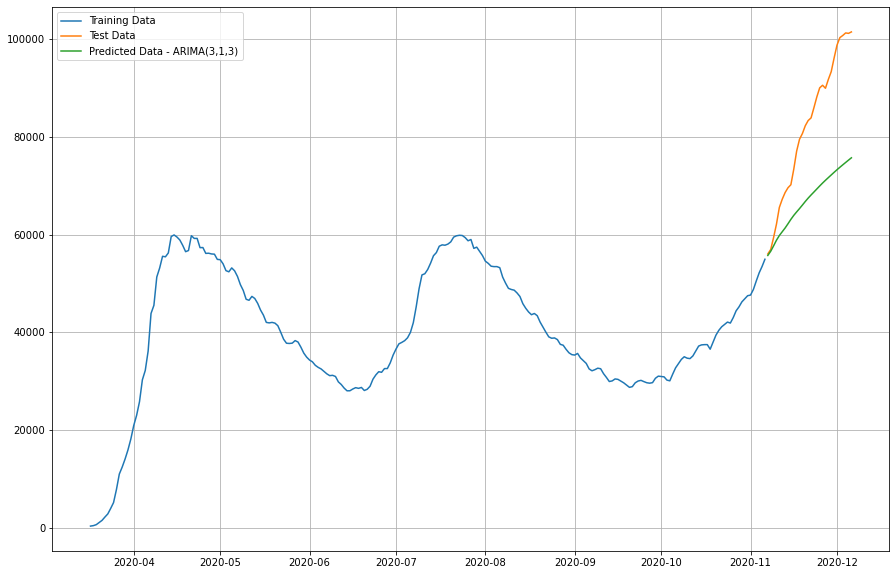

In [52]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - ARIMA(3,1,3)')
plt.legend(loc='best')
plt.grid();

## finding model residuals

In [53]:
residuals = test['Hospitalized'] - forecast[0]

In [54]:
residuals

Time_Stamp
2020-11-07      310.110173
2020-11-08      358.940252
2020-11-09     1705.100145
2020-11-10     3294.359544
2020-11-11     5751.678772
2020-11-12     6653.761633
2020-11-13     7251.879092
2020-11-14     7373.446877
2020-11-15     7088.910700
2020-11-16     9450.282034
2020-11-17    12440.747512
2020-11-18    14193.301957
2020-11-19    14639.979539
2020-11-20    15505.029074
2020-11-21    15879.652111
2020-11-22    15779.110258
2020-11-23    17265.051908
2020-11-24    18843.547297
2020-11-25    20091.416935
2020-11-26    20015.946279
2020-11-27    18834.946327
2020-11-28    20099.941686
2020-11-29    21152.409671
2020-11-30    23404.746443
2020-12-01    25505.587954
2020-12-02    26542.101676
2020-12-03    26481.228966
2020-12-04    26515.420933
2020-12-05    25947.561141
2020-12-06    25771.330377
Name: Hospitalized, dtype: float64

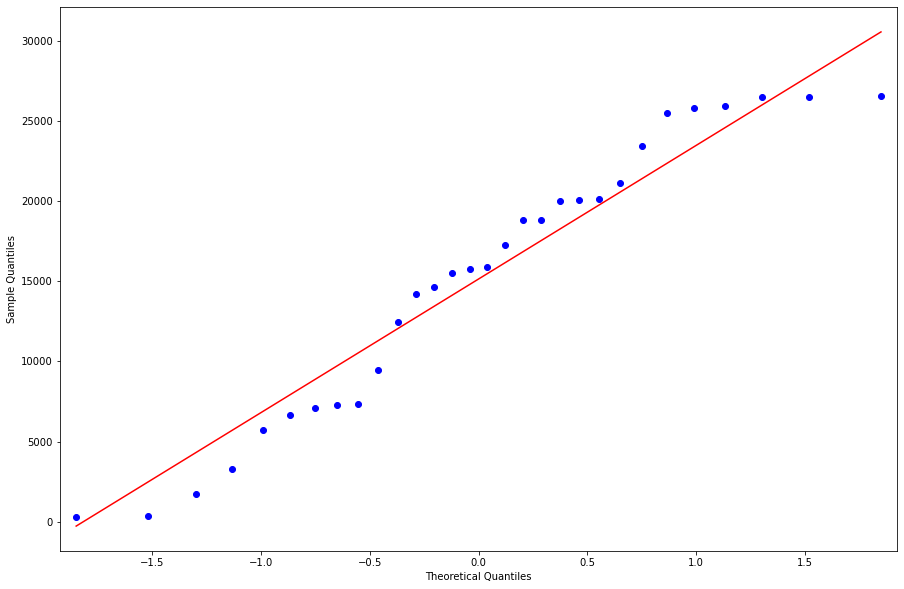

In [55]:
qqplot(residuals,line="s");

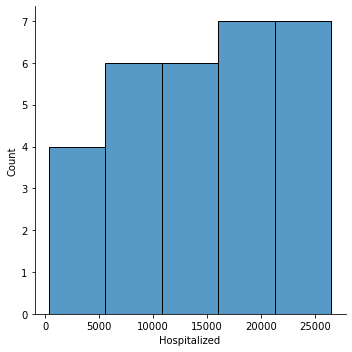

In [56]:
sns.displot(residuals,bins=5)

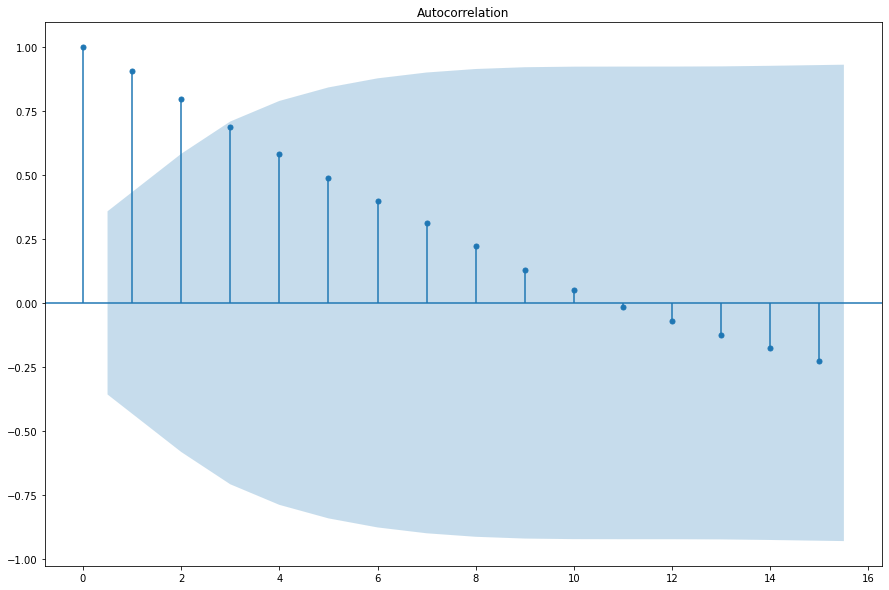

In [57]:
plot_acf(residuals);

<AxesSubplot:xlabel='Time_Stamp'>

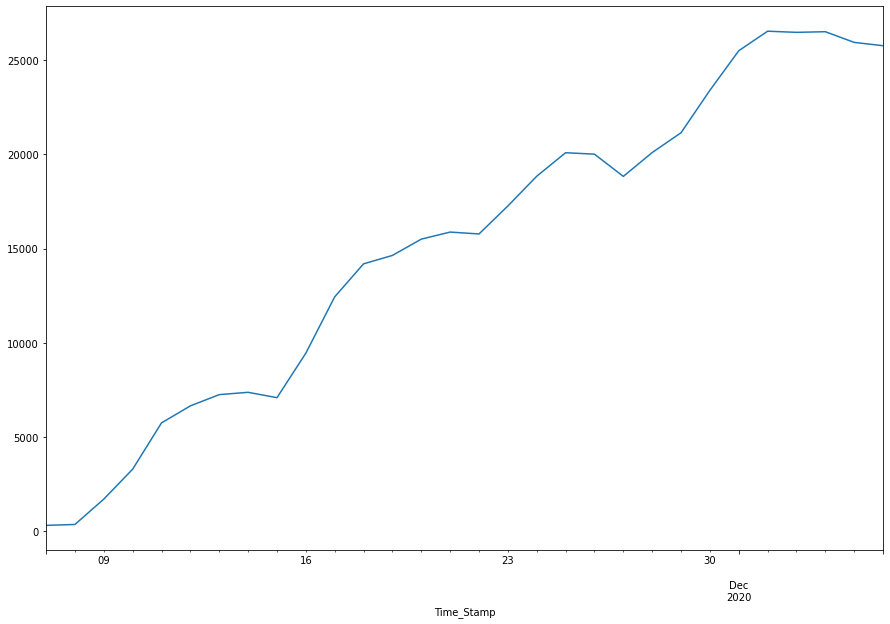

In [58]:
residuals.plot()

### distribution of residual plot confirms that model does not fit well with the series

## Calculating RSME and MAPE 

In [59]:
from math import sqrt
from sklearn.metrics import  mean_squared_error
rmse = sqrt(mean_squared_error(test['Hospitalized'],forecast[0]))
print(rmse)

17280.21083661614


In [60]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [61]:
mape = MAPE(test['Hospitalized'].values,forecast[0])
print(mape)

17.083410946557688


## creating new dataframe for storing the results

In [62]:
resultsDf = pd.DataFrame({'Test RMSE': rmse,'Test MAPE':mape}
                           ,index=['ARIMA(3,1,3)'])

resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17280.210837,17.083411


## Now to include seasonality, we will use SARIMA model

## we will find the model parameters based on AIC criteria. Parameters will be  generated using combination for the given range.

In [63]:
import itertools
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 7)
Model: (0, 1, 1)(0, 1, 2, 7)
Model: (0, 1, 2)(0, 1, 3, 7)
Model: (0, 1, 2)(1, 1, 0, 7)


In [64]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [65]:
model_pdq

[(0, 1, 0, 7),
 (0, 1, 1, 7),
 (0, 1, 2, 7),
 (0, 1, 3, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (1, 1, 3, 7),
 (2, 1, 0, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7),
 (2, 1, 3, 7),
 (3, 1, 0, 7),
 (3, 1, 1, 7),
 (3, 1, 2, 7),
 (3, 1, 3, 7)]

## Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [66]:
dfObj2 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj2

,param,seasonal,AIC


## model parameter selection using hypertuning

In [67]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = mod.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        dfObj2 = dfObj2.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:3822.7494164801446
SARIMA(0, 1, 0)x(0, 1, 1, 7)7 - AIC:3683.036460394303
SARIMA(0, 1, 0)x(0, 1, 2, 7)7 - AIC:3527.5169378039122
SARIMA(0, 1, 0)x(0, 1, 3, 7)7 - AIC:3371.4391723561594
SARIMA(0, 1, 0)x(1, 1, 0, 7)7 - AIC:3703.0274490956363
SARIMA(0, 1, 0)x(1, 1, 1, 7)7 - AIC:3668.2766151500714
SARIMA(0, 1, 0)x(1, 1, 2, 7)7 - AIC:3514.4569314113214
SARIMA(0, 1, 0)x(1, 1, 3, 7)7 - AIC:3366.4576774070674
SARIMA(0, 1, 0)x(2, 1, 0, 7)7 - AIC:3544.578288609922
SARIMA(0, 1, 0)x(2, 1, 1, 7)7 - AIC:3545.1420762625567
SARIMA(0, 1, 0)x(2, 1, 2, 7)7 - AIC:3524.1505789619614
SARIMA(0, 1, 0)x(2, 1, 3, 7)7 - AIC:3332.3425034236993
SARIMA(0, 1, 0)x(3, 1, 0, 7)7 - AIC:3384.547720082892
SARIMA(0, 1, 0)x(3, 1, 1, 7)7 - AIC:3369.965312300741
SARIMA(0, 1, 0)x(3, 1, 2, 7)7 - AIC:3362.795159058412
SARIMA(0, 1, 0)x(3, 1, 3, 7)7 - AIC:3348.0772063108843
SARIMA(0, 1, 1)x(0, 1, 0, 7)7 - AIC:3784.931219530636
SARIMA(0, 1, 1)x(0, 1, 1, 7)7 - AIC:3637.711856062512
SARIMA(0, 1, 1)x(

SARIMA(2, 1, 1)x(1, 1, 3, 7)7 - AIC:3204.9047413052094
SARIMA(2, 1, 1)x(2, 1, 0, 7)7 - AIC:3370.443512193527
SARIMA(2, 1, 1)x(2, 1, 1, 7)7 - AIC:3372.0071473671906
SARIMA(2, 1, 1)x(2, 1, 2, 7)7 - AIC:3342.354960501969
SARIMA(2, 1, 1)x(2, 1, 3, 7)7 - AIC:3206.1854479609415
SARIMA(2, 1, 1)x(3, 1, 0, 7)7 - AIC:3211.3113559166723
SARIMA(2, 1, 1)x(3, 1, 1, 7)7 - AIC:3208.584214075887
SARIMA(2, 1, 1)x(3, 1, 2, 7)7 - AIC:3215.8798165351063
SARIMA(2, 1, 1)x(3, 1, 3, 7)7 - AIC:3258.693043905863
SARIMA(2, 1, 2)x(0, 1, 0, 7)7 - AIC:3703.063889131461
SARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:3519.505322689776
SARIMA(2, 1, 2)x(0, 1, 2, 7)7 - AIC:3321.1229069771603
SARIMA(2, 1, 2)x(0, 1, 3, 7)7 - AIC:3206.4090364006033
SARIMA(2, 1, 2)x(1, 1, 0, 7)7 - AIC:3561.8543842699655
SARIMA(2, 1, 2)x(1, 1, 1, 7)7 - AIC:3515.3885811147347
SARIMA(2, 1, 2)x(1, 1, 2, 7)7 - AIC:3364.232890836918
SARIMA(2, 1, 2)x(1, 1, 3, 7)7 - AIC:3242.8002664961246
SARIMA(2, 1, 2)x(2, 1, 0, 7)7 - AIC:3372.3957109883563
SARIMA(2, 1, 2)x(

## sorting parameters for best AIC score

In [68]:
dfObj2.sort_values(by=['AIC'])

,param,seasonal,AIC
119,"(1, 1, 3)","(1, 1, 3, 7)",3163.016329
127,"(1, 1, 3)","(3, 1, 3, 7)",3165.558994
179,"(2, 1, 3)","(0, 1, 3, 7)",3168.592455
115,"(1, 1, 3)","(0, 1, 3, 7)",3172.726777
59,"(0, 1, 3)","(2, 1, 3, 7)",3178.455507
...,...,...,...
144,"(2, 1, 1)","(0, 1, 0, 7)",3723.913913
80,"(1, 1, 1)","(0, 1, 0, 7)",3741.798585
16,"(0, 1, 1)","(0, 1, 0, 7)",3784.931220
64,"(1, 1, 0)","(0, 1, 0, 7)",3786.837444


### SARIMA model parameters are selected as (1,1,3)(1,1,3,7)

In [69]:
model = sm.tsa.statespace.SARIMAX(train,
                                order=(1,1,3),
                                seasonal_order=(1,1,3,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_Sarima = model.fit()
print(model_Sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 7)   Log Likelihood               -1572.508
Date:                           Mon, 13 Sep 2021   AIC                           3163.016
Time:                                   12:41:46   BIC                           3192.791
Sample:                               03-17-2020   HQIC                          3175.063
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9366      0.018     51.761      0.000       0.901       0.972
ma.L1         -0.6459      0.062    -10.496

In [70]:
SARIMA_predictions=model_Sarima.forecast(steps=len(test))

In [71]:
SARIMA_predictions=model_Sarima.predict(start=pred_start, end=pred_end)

In [72]:
SARIMA_predictions

2020-11-07    55776.441162
2020-11-08    56266.596056
2020-11-09    57695.617931
2020-11-10    59515.722406
2020-11-11    61060.685412
2020-11-12    62274.644707
2020-11-13    63377.965702
2020-11-14    64111.603491
2020-11-15    64484.605404
2020-11-16    65938.319654
2020-11-17    67737.632367
2020-11-18    69239.643558
2020-11-19    70412.263772
2020-11-20    71449.001983
2020-11-21    72133.048711
2020-11-22    72472.345449
2020-11-23    73866.668328
2020-11-24    75603.078336
2020-11-25    77024.078395
2020-11-26    78137.372209
2020-11-27    79084.560998
2020-11-28    79720.088957
2020-11-29    80003.001709
2020-11-30    81368.024217
2020-12-01    83081.329632
2020-12-02    84493.856806
2020-12-03    85589.358578
2020-12-04    86540.132138
2020-12-05    87157.957987
2020-12-06    87430.811430
Freq: D, Name: predicted_mean, dtype: float64

## plotting model predictions

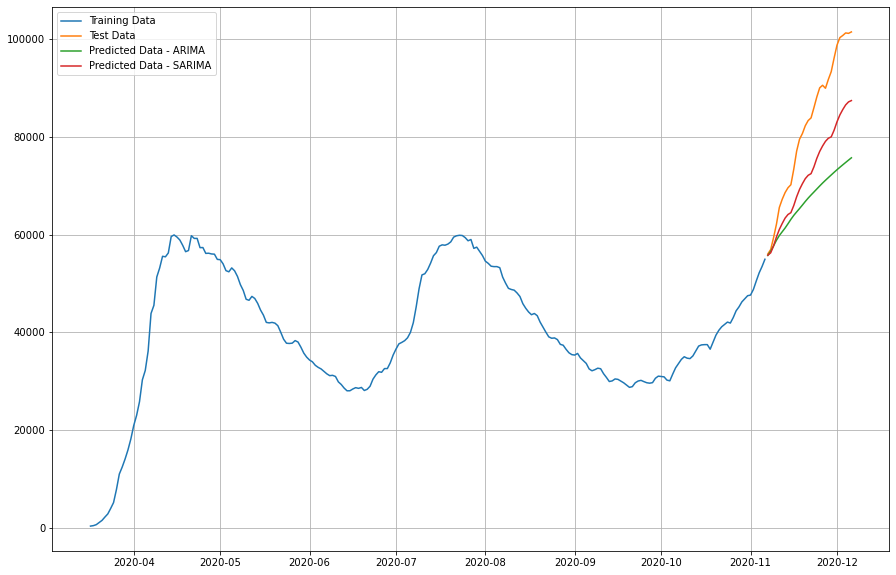

In [73]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid();

### It can be observed that SARIMA model is showing good seasonal considerations

## finding RSMA and MAPE

In [74]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMA_predictions))
print(rmse)

10799.510700956522


In [75]:
mape = MAPE(test.Hospitalized,SARIMA_predictions)
print(mape)

11.170211954725191


In [76]:
resultsDfsarima = pd.DataFrame({'Test RMSE': rmse, 'Test MAPE':mape}
                           ,index=['SARIMA(1, 1, 3)(1, 1, 3)7'])

resultsDf = pd.concat([resultsDf, resultsDfsarima])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17280.210837,17.083411
"SARIMA(1, 1, 3)(1, 1, 3)7",10799.510701,11.170212


## model residual analysis

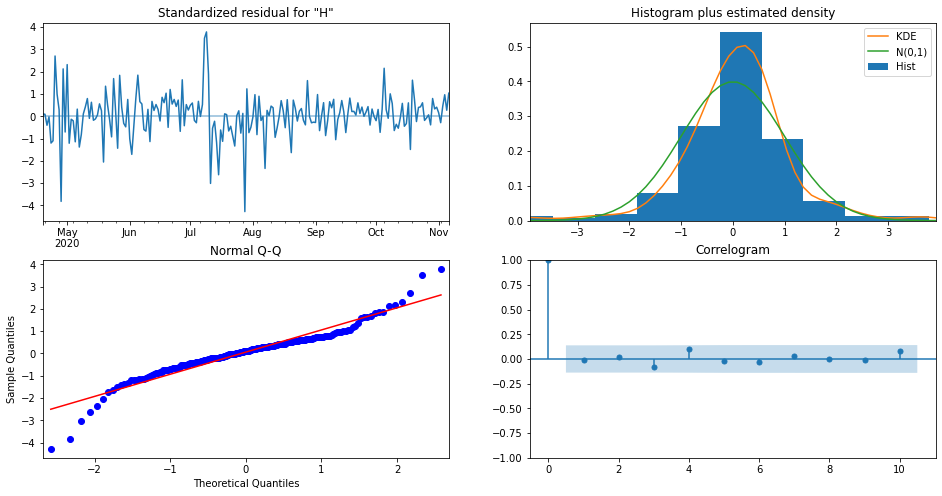

In [77]:
model_Sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## We will build SARIMAX model for forecasting Hospitalized count. For SARIMAX model,we will use Positive count as exog variable

In [78]:
ex=df[['Positive']]

In [79]:
ex

,Positive
Time_Stamp,
2020-03-17,10021
2020-03-18,13385
2020-03-19,18085
2020-03-20,24197
2020-03-21,31013
...,...
2020-12-02,13711156
2020-12-03,13921360
2020-12-04,14146191


## splitting exog variable into training and testing set

In [80]:
ex_train             = ex[:train_end]
ex_test              = ex[train_end + timedelta(days=1):test_end]

### Creating an empty Dataframe with column names only where the model and AIC scores will be saved

In [81]:
dfObj3 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
dfObj3

,param,seasonal,AIC


## model parameter selection using hypertuning

In [82]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        dfObj3 = dfObj3.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)

SARIMA(0, 1, 0)(0, 1, 0, 7) - AIC:3810.1050075808885
SARIMA(0, 1, 0)(0, 1, 1, 7) - AIC:3681.637084577785
SARIMA(0, 1, 0)(0, 1, 2, 7) - AIC:3519.8564136797104
SARIMA(0, 1, 0)(0, 1, 3, 7) - AIC:3364.5249249372296
SARIMA(0, 1, 0)(1, 1, 0, 7) - AIC:3690.631106381684
SARIMA(0, 1, 0)(1, 1, 1, 7) - AIC:3660.5914167024303
SARIMA(0, 1, 0)(1, 1, 2, 7) - AIC:3509.301219427727
SARIMA(0, 1, 0)(1, 1, 3, 7) - AIC:3364.568672202721
SARIMA(0, 1, 0)(2, 1, 0, 7) - AIC:3537.1174281564827
SARIMA(0, 1, 0)(2, 1, 1, 7) - AIC:3537.456312328264
SARIMA(0, 1, 0)(2, 1, 2, 7) - AIC:3499.3679227564444
SARIMA(0, 1, 0)(2, 1, 3, 7) - AIC:3309.2900878010973
SARIMA(0, 1, 0)(3, 1, 0, 7) - AIC:3378.937645196597
SARIMA(0, 1, 0)(3, 1, 1, 7) - AIC:3367.494002779669
SARIMA(0, 1, 0)(3, 1, 2, 7) - AIC:3367.413536006625
SARIMA(0, 1, 0)(3, 1, 3, 7) - AIC:3341.8447054449243
SARIMA(0, 1, 1)(0, 1, 0, 7) - AIC:3777.652921376637
SARIMA(0, 1, 1)(0, 1, 1, 7) - AIC:3632.221537832188
SARIMA(0, 1, 1)(0, 1, 2, 7) - AIC:3452.492539990478
SARI

SARIMA(2, 1, 1)(3, 1, 1, 7) - AIC:3245.592754748281
SARIMA(2, 1, 1)(3, 1, 2, 7) - AIC:3263.9452381881692
SARIMA(2, 1, 1)(3, 1, 3, 7) - AIC:3264.192699046235
SARIMA(2, 1, 2)(0, 1, 0, 7) - AIC:3701.383499545539
SARIMA(2, 1, 2)(0, 1, 1, 7) - AIC:3519.9613695630032
SARIMA(2, 1, 2)(0, 1, 2, 7) - AIC:3360.5080753594157
SARIMA(2, 1, 2)(0, 1, 3, 7) - AIC:3242.4312457458645
SARIMA(2, 1, 2)(1, 1, 0, 7) - AIC:3564.8270901692504
SARIMA(2, 1, 2)(1, 1, 1, 7) - AIC:3520.288739219931
SARIMA(2, 1, 2)(1, 1, 2, 7) - AIC:3368.9395030290507
SARIMA(2, 1, 2)(1, 1, 3, 7) - AIC:3241.600622903331
SARIMA(2, 1, 2)(2, 1, 0, 7) - AIC:3395.866693955637
SARIMA(2, 1, 2)(2, 1, 1, 7) - AIC:3392.5449284700458
SARIMA(2, 1, 2)(2, 1, 2, 7) - AIC:3364.420851786781
SARIMA(2, 1, 2)(2, 1, 3, 7) - AIC:3244.3074387471997
SARIMA(2, 1, 2)(3, 1, 0, 7) - AIC:3236.586883690493
SARIMA(2, 1, 2)(3, 1, 1, 7) - AIC:3258.7689258919304
SARIMA(2, 1, 2)(3, 1, 2, 7) - AIC:3260.776428127085
SARIMA(2, 1, 2)(3, 1, 3, 7) - AIC:3245.550291204202
SAR

## sorting parameters for AIC score

In [83]:
dfObj3.sort_values(by=['AIC'])

,param,seasonal,AIC
115,"(1, 1, 3)","(0, 1, 3, 7)",3174.056619
99,"(1, 1, 2)","(0, 1, 3, 7)",3189.450518
204,"(3, 1, 0)","(3, 1, 0, 7)",3196.367695
51,"(0, 1, 3)","(0, 1, 3, 7)",3199.820852
183,"(2, 1, 3)","(1, 1, 3, 7)",3201.954080
...,...,...,...
144,"(2, 1, 1)","(0, 1, 0, 7)",3722.142084
80,"(1, 1, 1)","(0, 1, 0, 7)",3740.790861
16,"(0, 1, 1)","(0, 1, 0, 7)",3777.652921
64,"(1, 1, 0)","(0, 1, 0, 7)",3782.661989


## We will build SARIMAX model of order (1,1,3)(0,1,3,7)

In [84]:
model = sm.tsa.statespace.SARIMAX(train,exog=ex_train,
                                order=(1,1,3),
                                seasonal_order=(0,1,3,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_sarimax = model.fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Hospitalized   No. Observations:                  235
Model:             SARIMAX(1, 1, 3)x(0, 1, 3, 7)   Log Likelihood               -1578.028
Date:                           Mon, 13 Sep 2021   AIC                           3174.057
Time:                                   12:49:27   BIC                           3203.831
Sample:                               03-17-2020   HQIC                          3186.103
                                    - 11-06-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Positive       0.0049      0.011      0.458      0.647      -0.016       0.026
ar.L1          0.8920      0.029     30.661

### model predictions

In [85]:
SARIMAX_predictions=model_sarimax.forecast(steps=len(test),exog=ex_test)

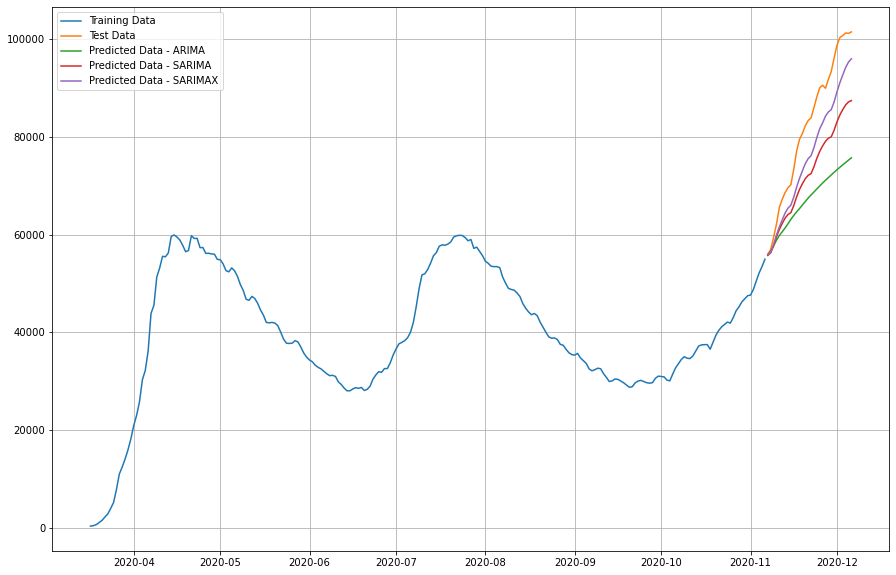

In [86]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid();

### SARIMAX model is predicting results quite close to actual data

## Residual analysis

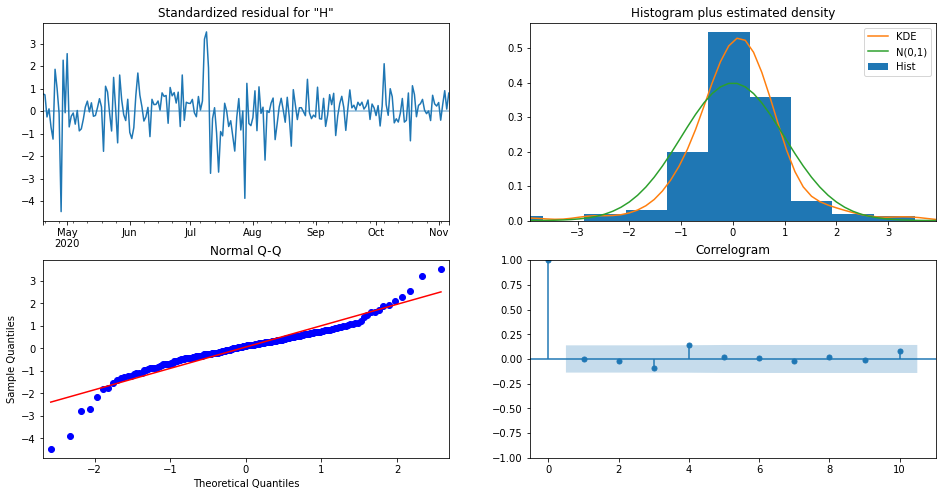

In [87]:
model_sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

### It can be observed that Model residuals are normally distributed and ACF plot also confirms that residuals are random

## Finding RSMA and MAPE

In [88]:
rmse = sqrt(mean_squared_error(test.Hospitalized,SARIMAX_predictions))
print(rmse)

6645.797735612455


In [89]:
mape = MAPE(test.Hospitalized,SARIMAX_predictions)
print(mape)

7.192403430530704


In [90]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['SARIMAX(1, 1, 3)(1, 1, 3)7'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17280.210837,17.083411
"SARIMA(1, 1, 3)(1, 1, 3)7",10799.510701,11.170212
"SARIMAX(1, 1, 3)(1, 1, 3)7",6645.797736,7.192403


## As series has seasonality and trend, lets try H-W model for forecasting Hospitalized count

In [91]:
model_TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')

In [92]:
model_TES = model_TES.fit(smoothing_level=0.8947529,smoothing_trend=0.459930,smoothing_seasonal=0.0664855,optimized=False)
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,235
Model:,ExponentialSmoothing,SSE,154597219.211
Optimized:,False,AIC,3170.236
Trend:,Additive,BIC,3208.291
Seasonal:,Additive,AICC,3171.883
Seasonal Periods:,7,Date:,"Mon, 13 Sep 2021"
Box-Cox:,False,Time:,12:49:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8947529,alpha,False
smoothing_trend,0.4599300,beta,False


In [93]:
TES_predictions =  model_TES.forecast(len(test))

In [94]:
error=test.Hospitalized-TES_predictions

In [95]:
error

Time_Stamp
2020-11-07     -16.212653
2020-11-08    -379.805110
2020-11-09     -36.718413
2020-11-10     604.470144
2020-11-11    2280.778043
2020-11-12    2559.817082
2020-11-13    2793.149379
2020-11-14    2612.688172
2020-11-15    1958.095715
2020-11-16    3024.182412
2020-11-17    4623.370968
2020-11-18    5318.678868
2020-11-19    5086.717907
2020-11-20    5551.050204
2020-11-21    5448.588997
2020-11-22    4715.996539
2020-11-23    4704.083237
2020-11-24    4796.271793
2020-11-25    4920.579692
2020-11-26    4046.618732
2020-11-27    2299.951028
2020-11-28    2942.489821
2020-11-29    3268.897364
2020-11-30    3951.984061
2020-12-01    4477.172618
2020-12-02    4279.480517
2020-12-03    3315.519557
2020-12-04    2703.851853
2020-12-05    1448.390646
2020-12-06     476.798189
dtype: float64

In [96]:
error.mean()

3125.897912053723

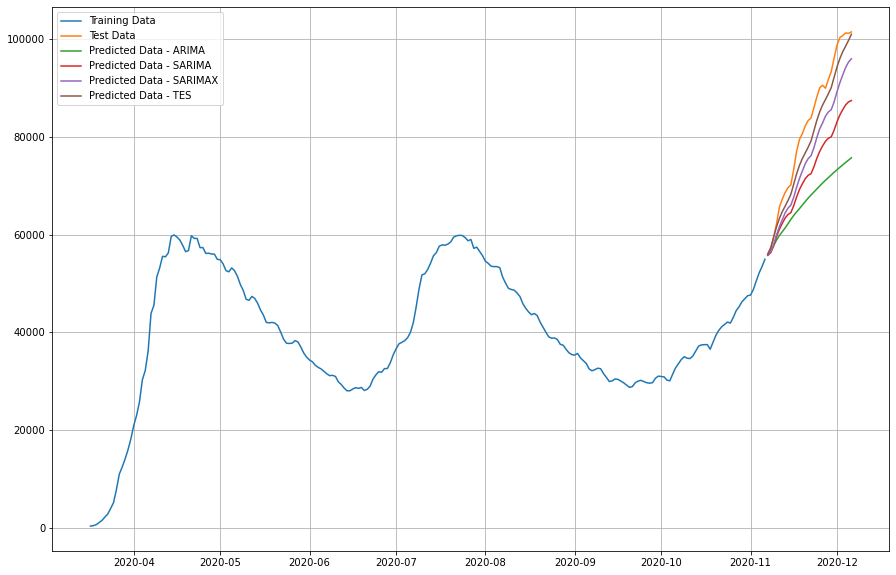

In [97]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - ARIMA')
plt.plot(test.index,SARIMA_predictions,label='Predicted Data - SARIMA')
plt.plot(test.index,SARIMAX_predictions,label='Predicted Data - SARIMAX')
plt.plot(test.index,TES_predictions,label='Predicted Data - TES')
plt.legend(loc='best')
plt.grid();

## finding RSME and MAPE

In [98]:
rmse = sqrt(mean_squared_error(test.Hospitalized,TES_predictions))
print(rmse)

3573.576317343179


In [99]:
mape = MAPE(test['Hospitalized'].values,TES_predictions.values)
print(mape)

3.75102474499525


In [100]:
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse,'Test MAPE': mape}
                           ,index=['TES'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE,Test MAPE
"ARIMA(3,1,3)",17280.210837,17.083411
"SARIMA(1, 1, 3)(1, 1, 3)7",10799.510701,11.170212
"SARIMAX(1, 1, 3)(1, 1, 3)7",6645.797736,7.192403
TES,3573.576317,3.751025


## Based on MAPE, selecting H-W model

In [101]:
model_TES = ExponentialSmoothing(df_final,trend='additive',seasonal='additive',initialization_method='estimated')

In [102]:
model_TES = model_TES.fit(smoothing_level=0.8947529,smoothing_trend=0.459930,smoothing_seasonal=0.0664855,optimized=False)

In [103]:
model_TES.summary()

Dep. Variable:,Hospitalized,No. Observations:,265
Model:,ExponentialSmoothing,SSE,173504125.597
Optimized:,False,AIC,3570.875
Trend:,Additive,BIC,3610.252
Seasonal:,Additive,AICC,3572.325
Seasonal Periods:,7,Date:,"Mon, 13 Sep 2021"
Box-Cox:,False,Time:,12:49:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8947529,alpha,False
smoothing_trend,0.4599300,beta,False


In [104]:
forecast= model_TES.forecast(20)

In [105]:
forecast

2020-12-07    102927.371165
2020-12-08    104178.703090
2020-12-09    104929.009284
2020-12-10    105147.901417
2020-12-11    105435.039313
2020-12-12    105808.534892
2020-12-13    106136.258110
2020-12-14    107564.118977
2020-12-15    108815.450903
2020-12-16    109565.757097
2020-12-17    109784.649230
2020-12-18    110071.787126
2020-12-19    110445.282705
2020-12-20    110773.005923
2020-12-21    112200.866790
2020-12-22    113452.198716
2020-12-23    114202.504910
2020-12-24    114421.397043
2020-12-25    114708.534938
2020-12-26    115082.030518
Freq: D, dtype: float64

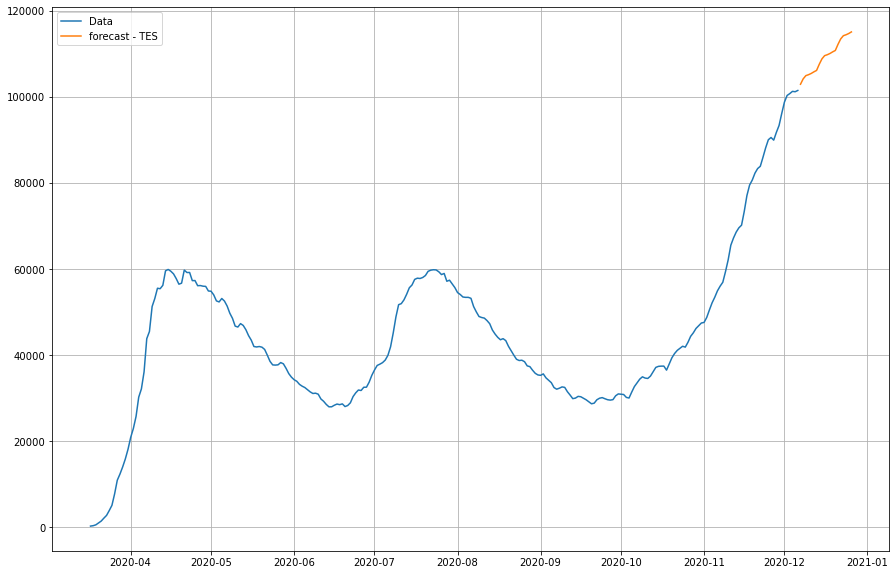

In [106]:
plt.plot(df_final,label='Data')
plt.plot(forecast,label='forecast - TES')
plt.legend(loc='best')
plt.grid();

# END